# Capstone 2 Modeling

In this notebook I'm going to prepare and evaluate several different models. Each model will be run across a range of hyperparameter values. Also, each model will be applied to 4 sets of outcome and predictor variables. I'll predict DNAtype based on amino acids, DNAtype based on codons, kingdom based on amino acids, and kingdom based on codons. Incorporating both the amino acid and codon data in a single model would be unwarranted, as the amino acid frequencies are linear combinations of the codon frequencies.  I'll begin with some imports:

In [3]:
import pandas as pd
import numpy as np
import xgboost as xg
import matplotlib.pyplot as plt
import hyperopt
from hyperopt import hp
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve, f1_score, auc, accuracy_score, log_loss, classification_report,confusion_matrix,roc_curve,roc_auc_score
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')



In [4]:
codon_list = ['UUU', 'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG',
       'AUU', 'AUC', 'AUA', 'AUG', 'GUU', 'GUC', 'GUA', 'GUG', 'GCU', 'GCC',
       'GCA', 'GCG', 'CCU', 'CCC', 'CCA', 'CCG', 'UGG', 'GGU', 'GGC', 'GGA',
       'GGG', 'UCU', 'UCC', 'UCA', 'UCG', 'AGU', 'AGC', 'ACU', 'ACC', 'ACA',
       'ACG', 'UAU', 'UAC', 'CAA', 'CAG', 'AAU', 'AAC', 'UGU', 'UGC', 'CAU',
       'CAC', 'AAA', 'AAG', 'CGU', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG', 'GAU',
       'GAC', 'GAA', 'GAG', 'UAA', 'UAG', 'UGA']

amino_list = ['alanine', 'arginine',
       'asparagine', 'aspartic acid', 'cysteine', 'glutamine', 'glutamic acid',
       'glycine', 'histidine', 'isoleucine', 'leucine', 'lysine', 'methionine',
       'phenylalanine', 'proline', 'serine', 'threonine', 'tryptophan',
       'tyrosine', 'valine', 'start', 'stop']

In [5]:
dnacols = ['D_chloroplast', 'D_genomic', 'D_mitochondrial']
kingcols = ['K_bacteria', 'K_virus', 'K_plant', 'K_vertebrate', 'K_invertebrate',
            'K_mammal', 'K_bacteriophage', 'K_rodent', 'K_primate', 'K_archaea']


In [6]:
# importing the csv from the preprocessing notebook
cu = pd.read_csv('codon_usage3.csv')
cu.head()

,Unnamed: 0,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,...,K_invertebrate,K_mammal,K_plant,K_primate,K_rodent,K_vertebrate,K_virus,D_chloroplast,D_genomic,D_mitochondrial
0,0,virus,genomic,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,...,0,0,0,0,0,0,1,0,1,0
1,1,virus,genomic,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,...,0,0,0,0,0,0,1,0,1,0
2,2,virus,genomic,100755,4862,Sweet potato leaf curl virus,0.01974,0.02180,0.01357,0.01543,...,0,0,0,0,0,0,1,0,1,0
3,3,virus,genomic,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,...,0,0,0,0,0,0,1,0,1,0
4,4,virus,genomic,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,...,0,0,0,0,0,0,1,0,1,0


In [21]:
# it could be useful to store the results for all of these models 
# some of these will be dict()s - which may be a challenge, but seems like the best solution
# I hate having model_id as a column but I see no good alternative

r_cols = ['model_id', 'model_type', 'inputs', 'outputs', 'hyperparameters', 'assessment', 'start_time', 'run_time'] 
results = pd.DataFrame(columns = r_cols)

results


,model_id,model_type,inputs,outputs,hyperparameters,assessment,start_time,run_time


## Principal Component Analysis

component: 1 var exp: 0.36014429915649687
component: 2 var exp: 0.22580436696206713
component: 3 var exp: 0.06282672178613029
component: 4 var exp: 0.037815009913713116
component: 5 var exp: 0.028781176122513075
component: 6 var exp: 0.022230250408107843
component: 7 var exp: 0.021106017746944563
component: 8 var exp: 0.017959101779997592
0.7766669438759705


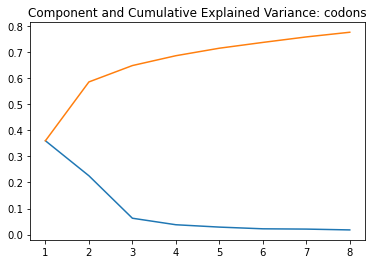

In [8]:
# it could also be interesting at this stage to try PCA:

c = 8
pca = PCA(n_components=c)
pca_fit = pca.fit_transform(cu[codon_list].values)

plt.plot(range(1,c+1), pca.explained_variance_ratio_)
plt.plot(range(1,c+1), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component and Cumulative Explained Variance: codons")

for i in range(0,c):
    print('component:', i+1, 'var exp:', pca.explained_variance_ratio_[i])

print(sum(pca.explained_variance_ratio_))

I neglected to use StandardScaler() first. It's interesting to see just how much these variance components are inflated in the absence of standardization.  Let's try again.

component: 1 var exp: 0.29791063472512713
component: 2 var exp: 0.18665155166735742
component: 3 var exp: 0.05561275103891307
component: 4 var exp: 0.040281590442290856
component: 5 var exp: 0.03458769954466623
component: 6 var exp: 0.02979526024251018
component: 7 var exp: 0.023207993323854304
component: 8 var exp: 0.02211201583224159
0.6901594968169608


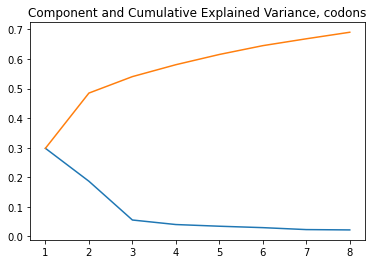

In [9]:
ss = StandardScaler()
codon_ss = ss.fit_transform(cu[codon_list])

c = 8
pca = PCA(n_components=c)
pca_fit = pca.fit_transform(codon_ss)

plt.plot(range(1,c+1), pca.explained_variance_ratio_)
plt.plot(range(1,c+1), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component and Cumulative Explained Variance, codons")

for i in range(0,c):
    print('component:', i+1, 'var exp:', pca.explained_variance_ratio_[i])

print(sum(pca.explained_variance_ratio_))

component: 1 var exp: 0.33484361322408024
component: 2 var exp: 0.16019205982815307
component: 3 var exp: 0.07964782429330998
component: 4 var exp: 0.07353787039451537
component: 5 var exp: 0.05286574554319708
component: 6 var exp: 0.04626117484582925
component: 7 var exp: 0.035441191391069375
component: 8 var exp: 0.03414581603885486
0.8169352955590092


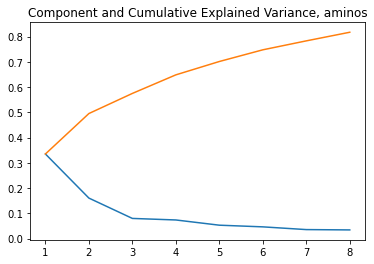

In [10]:
# let's also try this on aminos

ss = StandardScaler()
amino_ss = ss.fit_transform(cu[amino_list])

c = 8
pca = PCA(n_components=c)
pca_fit = pca.fit_transform(amino_ss)

plt.plot(range(1,c+1), pca.explained_variance_ratio_)
plt.plot(range(1,c+1), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component and Cumulative Explained Variance, aminos")

for i in range(0,c):
    print('component:', i+1, 'var exp:', pca.explained_variance_ratio_[i])

print(sum(pca.explained_variance_ratio_))

If we apply the 'elbow method' as one might in, say, k-means clustering, it suggests that applying models to just 3 principal components might be useful.  Still, this only explains only 69% of the variance - if we extend this graph to many components, it has a very long tail.  I'm unconvinced that it would really be beneficial to apply some kind of dimensionality reduction.  But I might return to this later.

### K-Nearest Neighbors

K-NN might not be the model type most likely to prove useful, but it has only a single hyperparameter (k, the number of neighbors) to consider.  I'll incorporate everything I need to do into a simple function, this will help avoid tragic mistakes and simplify the work.

In [25]:
'''It is EXTREMELY PAINFUL to me that it proved necessary to include Xn and yn to represent the NAMES of the 
parameters X and y in the function below.  I looked long and hard and ultimately in vain for a clean, simple way
to obtain the name of a variable as a string.  Perhaps this is possible, but I was more concerned about getting
the function to work.''' 

def knn_fit(y, X, yn='', Xn='', max_k=8, tts_random_state=0, test_id=0, do_plots=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=tts_random_state)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=tts_random_state+1)
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_val = ss.transform(X_val)
    X_test = ss.transform(X_test)
    
    output = pd.DataFrame(columns=r_cols)
    train_a = []
    test_a = []
    val_a = []
    train_f1 = []
    test_f1 = []
    val_f1 = []
    train_ra = []
    test_ra = []
    val_ra = []
    
    for i in range(1, max_k+1):
        starttime = datetime.now()
        knn = KNeighborsClassifier(i)
        knn.fit(X_train,y_train)
     
        train_pred = knn.predict(X_train)
        test_pred = knn.predict(X_test)
        val_pred = knn.predict(X_val)
        
        train_prob_pred = knn.predict_proba(X_train)
        test_prob_pred = knn.predict_proba(X_test)
        val_prob_pred = knn.predict_proba(X_val)
        
        test_a.append(accuracy_score(y_test, test_pred))
        train_a.append(accuracy_score(y_train, train_pred))
        val_a.append(accuracy_score(y_val, val_pred))
        
        test_f1.append(f1_score(y_test, test_pred, average='micro'))
        train_f1.append(f1_score(y_train, train_pred, average='micro'))
        val_f1.append(f1_score(y_val, val_pred, average='micro'))
        
        # according to the sklearn docs, roc_auc requires predict_proba; this failed to work
        test_ra.append(roc_auc_score(y_test, test_pred, average='weighted', multi_class='ovo'))
        train_ra.append(roc_auc_score(y_train, train_pred, average='weighted', multi_class='ovo'))
        val_ra.append(roc_auc_score(y_val, val_pred, average='weighted', multi_class='ovo'))
        item = [test_id, 'kNN', Xn, yn, {'k':i}, {'train_f1':train_f1[-1], 'val_f1':val_f1[-1], 'test_f1':test_f1[-1],  
                                                  'train_accuracy':train_a[-1], 'val_accuracy':val_a[-1],'test_accuracy':test_a[-1], 
                                                  'train_roc_auc':test_ra[-1], 'val_roc_auc':val_ra[-1], 'test_roc_auc':test_ra[-1]},
                                                    starttime, datetime.now()-starttime]
        itemdict = dict(zip(r_cols, item))
        output = output.append(itemdict, ignore_index=True)

    if do_plots == True:
        title = 'k-NN predicting ' + yn + ' using ' + Xn
        line1, = plt.plot(range(1, max_k+1), train_a, 'b')
        line2, = plt.plot(range(1, max_k+1), val_a, 'g')
        line3, = plt.plot(range(1, max_k+1), test_a, 'r')
        plt.legend([line1, line2, line3], ['training accuracy', 'validation accuracy', 'testing accuracy'])
        plt.title(title)
        plt.ylabel('accuracy')
        plt.xlabel('k')
        plt.show() 
        
        line1, = plt.plot(range(1, max_k+1), train_f1, 'b')
        line2, = plt.plot(range(1, max_k+1), val_f1, 'g')
        line3, = plt.plot(range(1, max_k+1), test_f1, 'r')
        plt.legend([line1, line2, line3], ['training F1', 'validation F1', 'testing F1'])
        plt.title(title)
        plt.ylabel('F1')
        plt.xlabel('k')
        plt.show() 
        
        line1, = plt.plot(range(1, max_k+1), train_ra, 'b')
        line2, = plt.plot(range(1, max_k+1), val_ra, 'g')
        line3, = plt.plot(range(1, max_k+1), test_ra, 'r')
        plt.legend([line1, line2, line3], ['training roc_auc', 'validation roc_auc', 'testing roc_auc'])
        plt.title(title)
        plt.ylabel('roc_auc')
        plt.xlabel('k')
        plt.show() 
    
    else:
        pass
    
    return output

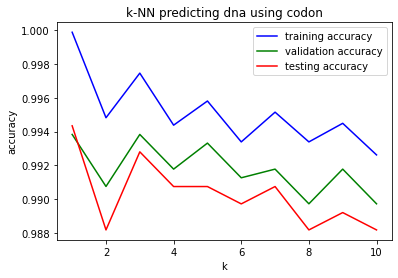

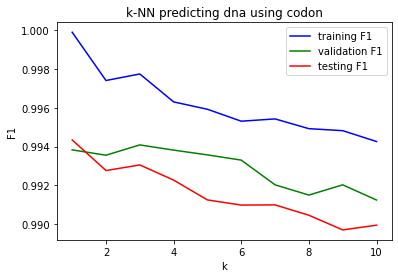

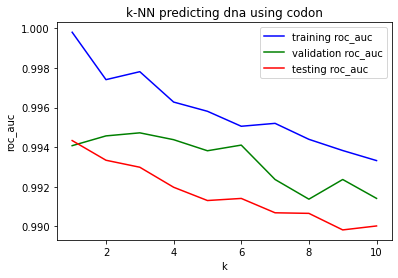

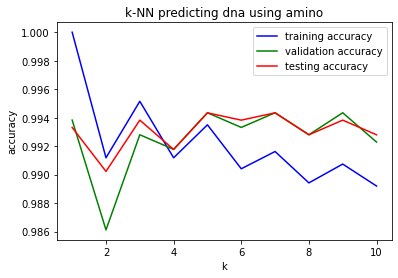

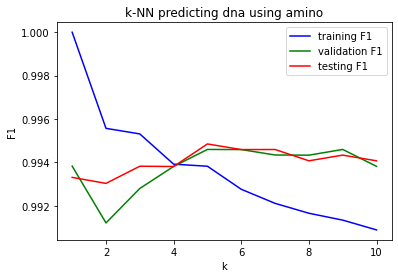

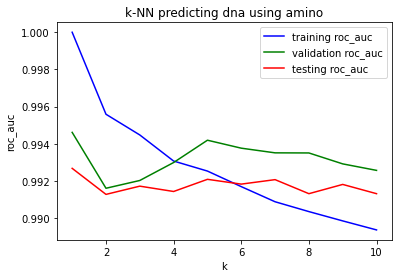

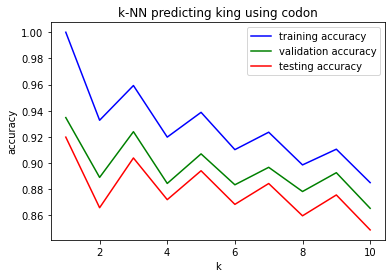

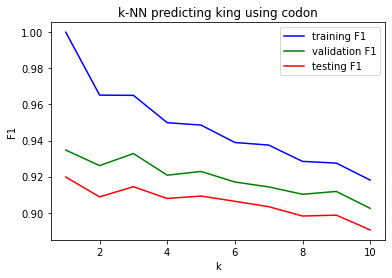

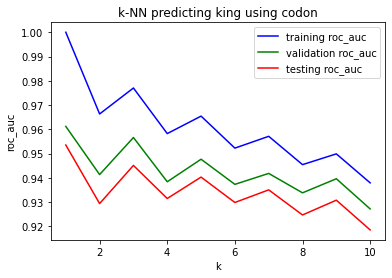

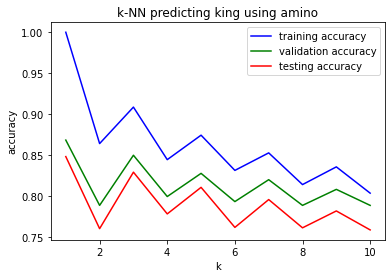

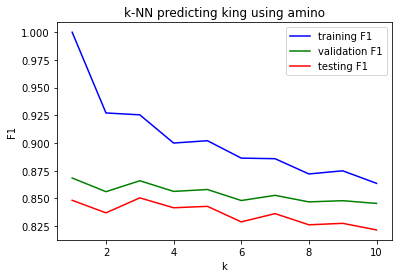

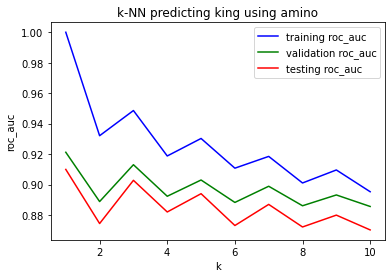

In [26]:
# predicting dna on codon, dna on amino, kingdom on codon, kingdom on amino
results=results.append(knn_fit(cu[dnacols], cu[codon_list], 'dna', 'codon', max_k=10, tts_random_state=1331, test_id='1001001', do_plots=True), ignore_index=True)
results=results.append(knn_fit(cu[dnacols], cu[amino_list], 'dna', 'amino', max_k=10, tts_random_state=382, test_id='1002001', do_plots=True), ignore_index=True)
results=results.append(knn_fit(cu[kingcols], cu[codon_list], 'king', 'codon', max_k=10, tts_random_state=88121, test_id='1003001', do_plots=True), ignore_index=True)
results=results.append(knn_fit(cu[kingcols], cu[amino_list], 'king', 'amino', max_k=10, tts_random_state=88121, test_id='1004001', do_plots=True), ignore_index=True)

In [19]:
list(results.assessment)


[{'train_f1': 0.9998897950187349,
  'test_f1': 0.9943415637860082,
  'val_f1': 0.9938303341902314,
  'train_accuracy': 0.9998897950187349,
  'test_accuracy': 0.9943415637860082,
  'val_accuracy': 0.9938303341902314,
  'train_roc_auc': 0.9943306158997849,
  'test_roc_auc': 0.9943306158997849,
  'val_roc_auc': 0.9940725005549521},
 {'train_f1': 0.9974034583724657,
  'test_f1': 0.992764857881137,
  'val_f1': 0.9935550399587523,
  'train_accuracy': 0.9948203658805378,
  'test_accuracy': 0.9881687242798354,
  'val_accuracy': 0.990745501285347,
  'train_roc_auc': 0.9933359096991289,
  'test_roc_auc': 0.9933359096991289,
  'val_roc_auc': 0.994566638756823},
 {'train_f1': 0.9977401752742104,
  'test_f1': 0.9930537689735015,
  'val_f1': 0.9940858832604784,
  'train_accuracy': 0.9974652854309015,
  'test_accuracy': 0.992798353909465,
  'val_accuracy': 0.9938303341902314,
  'train_roc_auc': 0.9929821230796064,
  'test_roc_auc': 0.9929821230796064,
  'val_roc_auc': 0.9947212282476611},
 {'train_f1

Overall, these scores are higher than expected. It's interesting (and probably important) that higher assessment metrics were obtained in the models predicting DNA type than in the models predicting kingdom.  Perhaps the most noteworthy feature observable from these graphs is that, for the k-NN models predicting DNA type from the amino frequencies, **some of the test scores are higher than the train scores.**  As I understand it, this is a sure sign that something has gone glaringly wrong. What's happening here?  If there were some kind of problem in cleaning or preprocessing, wouldn't the same problem manifest itself in the other three test cases?

**Update**: Having considered that perhaps there was some data leakage from the preprocessing notebook, I removed the StandardScaler() function from that stage and conducted it **after** the train-test split.  The results are the same.  Not understanding why this is happening is like a stone in my shoe, but I have to move on.


In [ ]:
results['assessment'][4].get('train_f1')

    

This is as expected; the 'results' dataframe appears to be storing the results as intended.

## Random Forest

I'm going to start with a single random forest model, and assess feature importance.

In [ ]:
y = cu[dnacols]
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=133)

rfc = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = rfc.fit(X_train, y_train)
y_pred = model_res.predict(X_test)

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')


print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

In [ ]:
feature_importance = rfc.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
y = cu[dnacols]
X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1863)

rfc = RandomForestClassifier(n_estimators=300, random_state = 531,n_jobs=-1)
model_res = rfc.fit(X_train, y_train)
y_pred = model_res.predict(X_test)

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')


print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

feature_importance = rfc.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

As when examining the results of PCA:  it's interesting how quickly the relative importance drops off.  Maybe I should compare some models using a restricted feature set.

In [ ]:
# I'll try modifying the same function as above for k-NN

def rfc_fit(y, X, yn='', Xn='', min_n_est=200, n_est_step=20, n_est_steps=11, tts_random_state=0, rfc_random_state=0, test_id=0, do_plots=False):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=tts_random_state)
    
    train_a = []
    test_a = []
    train_f1 = []
    test_f1 = []
    train_ra = []
    test_ra = []
    output = pd.DataFrame(columns=r_cols)
    
    for i in range(n_est_steps):
        starttime = datetime.now()
        rfc = RandomForestClassifier(n_estimators=min_n_est+n_est_step*i, random_state=rfc_random_state, n_jobs=-1)
        rfc.fit(X_train,y_train)
     
        train_pred = rfc.predict(X_train)
        test_pred = rfc.predict(X_test)
        train_prob_pred = rfc.predict_proba(X_train)
        test_prob_pred = rfc.predict_proba(X_test)
    
        test_a.append(accuracy_score(y_test, test_pred))
        train_a.append(accuracy_score(y_train, train_pred))
    
        test_f1.append(f1_score(y_test, test_pred, average='micro'))
        train_f1.append(f1_score(y_train, train_pred, average='micro'))
        
        # according to the sklearn docs, roc_auc requires predict_proba; this failed to work
        test_ra.append(roc_auc_score(y_test, test_pred, average='weighted', multi_class='ovo'))
        train_ra.append(roc_auc_score(y_train, train_pred, average='weighted', multi_class='ovo'))
    
        
    for i in range(n_est_steps):
        item = [test_id, 'RFC', Xn, yn, {'n_estimators':min_n_est+n_est_step*i}, {'train_f1':train_f1[i], 'test_f1':test_f1[i],
                                                  'train_accuracy':train_a[i], 'test_accuracy':test_a[i], 
                                                  'train_roc_auc':test_ra[i], 'test_roc_auc':test_ra[i]}, 
                                                    starttime, datetime.now()-starttime]
        itemdict = dict(zip(r_cols, item))
        output = output.append(itemdict, ignore_index=True)

    if do_plots == True:
        title = 'RFC predicting ' + yn + ' using ' + Xn
        line1, = plt.plot(range(n_est_steps), train_a, 'b')
        line2, = plt.plot(range(n_est_steps), test_a, 'g')
        plt.legend([line1, line2], ['training accuracy', 'testing accuracy'])
        plt.title(title)
        plt.ylabel('accuracy')
        plt.xlabel('k')
        plt.show() 
        
        line1, = plt.plot(range(n_est_steps), train_f1, 'b')
        line2, = plt.plot(range(n_est_steps), test_f1, 'g')
        plt.legend([line1, line2], ['training F1', 'testing F1'])
        plt.title(title)
        plt.ylabel('F1')
        plt.xlabel('k')
        plt.show() 
        
        line1, = plt.plot(range(n_est_steps), train_ra, 'b')
        line2, = plt.plot(range(n_est_steps), test_ra, 'g')
        plt.legend([line1, line2], ['training roc_auc', 'testing roc_auc'])
        plt.title(title)
        plt.ylabel('roc_auc')
        plt.xlabel('k')
        plt.show() 
    
    else:
        pass
    
    return output

In [ ]:
# running the function on:
# y=DNAtype X=codon
results = results.append(rfc_fit(cu[dnacols], cu[codon_list], 'dna', 'codon', test_id='2001001', tts_random_state=55, do_plots=True), ignore_index=True)
# y=DNAtype X=amino
results = results.append(rfc_fit(cu[dnacols], cu[amino_list], 'dna', 'amino', test_id='2002001', tts_random_state=12, do_plots=True), ignore_index=True)
# y=kingdom X=codon
results = results.append(rfc_fit(cu[kingcols], cu[codon_list], 'kingdom', 'codon', test_id='2003001', tts_random_state=63, do_plots=True), ignore_index=True)
# y=kingdom X=amino
results = results.append(rfc_fit(cu[kingcols], cu[amino_list], 'kingdom', 'amino', test_id='2004001', tts_random_state=40, do_plots=True), ignore_index=True)

The only difference seems to be that, when predicting kingdom as opposed to DNAtype, the testing accuracy drops substantially.  In all cases, the uniformly high training accuracy (at of very close to 1) is suspicious.  I suspect that I'll need to adjust some other parameters for the Random Forest classifier in order to  produce a model that's actually useful. Let's examine the results so far:

In [ ]:
results

84 rows is just what I expect so far.  Let's continue.

## XGBoost


It turns out that XGBClassifier doesn't require, and indeed, can't accept one-hot encoding.  I had to go back to preprocessing and restore the original 'Kingdom' and 'DNAtype' columns.  Also, I discovered that XGBClassifier's own label encoder is deprecated. Eliminating warnings about this requires another import.  **Turns out that, although XGBClassifier still accepted the encoding, this didn't mute the warnings.**

In [ ]:
from sklearn.preprocessing import LabelEncoder

# I'm not positive that instantiating two LabelEncoder() objects is necessary
# I'm also not positive it's not, and not worth the time to check right now
encoder1 = LabelEncoder()
encoder2 = LabelEncoder()
cu['DNAcode'] = encoder1.fit_transform(cu['DNAtype'])
cu['Kingcode'] = encoder2.fit_transform(cu['Kingdom'])

cu['DNAcode'].value_counts()

This looks like the distribution of DNAtype and Kingdom.  I'll proceed to apply XGBoost to these encoded y columns.

In [ ]:
list(cu.columns)

In [ ]:
# trying again:  DNAtype on codon_list, default hyperparams
test_id = '3001001'
yn = 'dna'
Xn = 'codon'
y = cu['DNAcode']
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13013)
starttime = datetime.now()
xgb = xg.XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovo')
item = [test_id, 'XGB', Xn, yn, {'hyperparameters':'XGBClassifier defaults'}, 
                                {'accuracy':acc, 'f1':f1, 'roc_auc':roc_auc}, 
                                starttime, datetime.now()-starttime]
itemdict = dict(zip(r_cols, item))
results = results.append(itemdict, ignore_index=True)

Did this work?  Accuracy can be equal to F1, but never greater, right?  Obviously, though, hyperparameter tuning remains a pretty big deal here.

In [ ]:
# XGBoost:  DNAcols predicted by aminos
test_id = '3002001'
yn = 'dna'
Xn='amino'
y = cu['DNAcode']
X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19044)
starttime = datetime.now()
xgb = xg.XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovo')
item = [test_id, 'XGB', Xn, yn, {'hyperparameters':'XGBClassifier defaults'}, {'accuracy':acc, 'f1':f1, 
                                                                               'roc_auc':roc_auc}, starttime, datetime.now()-starttime]
itemdict = dict(zip(r_cols, item))
results = results.append(itemdict, ignore_index=True)

In [ ]:
# XGBoost:  kingdom predicted by codons
test_id = '3003001'
yn = 'king'
Xn='codon'
y = cu['Kingcode']
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19044)
starttime = datetime.now()
xgb = xg.XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovo')
item = [test_id, 'XGB', Xn, yn, {'hyperparameters':'XGBClassifier defaults'}, {'accuracy':acc, 'f1':f1, 
                                                                               'roc_auc':roc_auc}, starttime, datetime.now()-starttime]
itemdict = dict(zip(r_cols, item))
results = results.append(itemdict, ignore_index=True)

In [ ]:
results.tail()

In [ ]:
# XGBoost:  kingdom predicted by aminos
test_id = '3004001'
yn = 'king'
Xn='amino'
y = cu['Kingcode']
X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19044)
starttime = datetime.now()
xgb = xg.XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovo')
item = [test_id, 'XGB', Xn, yn, {'hyperparameters':'XGBClassifier defaults'}, {'accuracy':acc, 'f1':f1, 
                                                                               'roc_auc':roc_auc}, starttime, datetime.now()-starttime]
itemdict = dict(zip(r_cols, item))
results = results.append(itemdict, ignore_index=True)

In [ ]:
results

I don't know what to get out of this.  At least I got XGBoost to work; there are so many hyperparameters, though, that I'm not sure how to go about tuning them.  Nor am I sure how to evaluate these models, other than by such metrics as accuracy, F1, etc.

## XGBClassifier using Hyperopt

In [ ]:
import hyperopt
from hyperopt import hp
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
# attempting to use hyperopt to select XGBoost hyperparameters
# starting out by cribbing from https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning


test_id = '3101001'
yn = 'dna'
Xn = 'codon'

y = cu['DNAcode']
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6016)
starttime = datetime.now()
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    model=xg.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovo')
    
    return {'loss': -f1, 'accuracy': accuracy, 'roc_auc': roc_auc, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = hyperopt.fmin(fn = objective,
                        space = space,
                        algo = hyperopt.tpe.suggest,
                        max_evals = 100,
                        trials = trials)


item = [test_id, 'XGB', Xn, yn, best_hyperparams, trials, starttime, datetime.now()-starttime]
itemdict = dict(zip(r_cols, item))
results = results.append(itemdict, ignore_index=True)


In [ ]:
dir(trials)

In [ ]:
trials.trials

In [ ]:
# DNA on amino 

test_id = '3102001'
yn = 'dna'
Xn = 'amino'

y = cu['DNAtype']
X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6016)
starttime = datetime.now()

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    model=xg.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovo')
    return {'loss': -f1, 'accuracy': accuracy, 'roc_auc': roc_auc, 'status': STATUS_OK }


trials = Trials()

best_hyperparams = hyperopt.fmin(fn = objective,
                        space = space,
                        algo = hyperopt.tpe.suggest,
                        max_evals = 100,
                        trials = trials)

item = [test_id, 'XGB', Xn, yn, best_hyperparams, trials, starttime, datetime.now()-starttime]
itemdict = dict(zip(r_cols, item))
results = results.append(itemdict, ignore_index=True)


Interesting.  Hyperopt optimizes to radically different hyperparameters using  F1 compared to accuracy.  Let's see if this holds across the other three tests to be run.

In [ ]:
# kingdom on codons

test_id = '3103001'
yn = 'kingdom'
Xn = 'codon'

y = cu['Kingdom']
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1613)
starttime = datetime.now()
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    model=xg.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovo')
    return {'loss': -f1, 'accuracy': accuracy, 'roc_auc': roc_auc, 'status': STATUS_OK }


trials = Trials()

best_hyperparams = hyperopt.fmin(fn = objective,
                        space = space,
                        algo = hyperopt.tpe.suggest,
                        max_evals = 100,
                        trials = trials)

item = [test_id, 'XGB', Xn, yn, best_hyperparams, trials, starttime, datetime.now()-starttime]
itemdict = dict(zip(r_cols, item))
results = results.append(itemdict, ignore_index=True)

In [ ]:
# kingdom on amino

test_id = '3104001'
yn = 'kingdom'
Xn = 'amino'

y = cu['Kingdom']
X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6016)
starttime = datetime.now()

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    model=xg.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovo')
    return {'loss': -f1, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = hyperopt.fmin(fn = objective,
                        space = space,
                        algo = hyperopt.tpe.suggest,
                        max_evals = 100,
                        trials = trials)

item = [test_id, 'XGB', Xn, yn, best_hyperparams, trials, starttime, datetime.now()-starttime]
itemdict = dict(zip(r_cols, item))
results = results.append(itemdict, ignore_index=True)

In [ ]:
results.tail(10)

In [ ]:
assess = results['assessment']
for i in range(1,11):
    print(assess.iloc[-i])

In [ ]:
hyper = results['hyperparameters']
for i in range(1,11):
    print(hyper.iloc[-i])

Ok, this is very clearly a problem:  the last five models trained have **exactly** the same accuracy, f1, and roc_auc; the hyperparameter values are distinct. In fact, they're quite different.  This is not plausible - something has gone wrong.  I don't think these hyperopt runs are saving the assessment scores that I intend, they're saving these values from the last run I conducted before using hyperopt.  I'm going to need to examine the Trials() objects.

In [ ]:
trials.results

In [ ]:
trials.average_best_error()

## Some concerns that seem pretty serious to me:
1. Apparently, I can get the "average_best_error()" method returned for a Trials() object.  But this, apparently, is only going to give me the metric I'm returning as the loss function.  Can I incorporate other measures (accuracy, roc_auc) into the return that provides the .results attribute in Trials()?  Or is there some better, cleaner way to obtain the measures I want for the 'best hyperparameters' case?
2. Of more practical concern: I was expecting the loss function to bounce around a little, but generally to trend toward some kind of minimum.  I don't see that **at all** in the above results - which makes me think that the problem isn't at all that max_evals is set too low.  (In some sandboxing, I found quite different results, but this was using hyperopt on simple algebraic functions of one variable.)  It really looks like the loss function is just bouncing around, as though hyperopt is just making shots in the dark.  I have to seriously question whether I would obtain even slightly consistent results if I were to repeat the optimization.
3. If the average_best_error() provided above is correct, it corresponds to an F1 score of 0.7154.  This is mediocre at best, and, most troubling:  it's **substantially** lower than the F1 score (0.8704) for the corresponding XGBClassifier model that I ran using default hyperparameters - with no optimization of any kind.  Why would optimizing over a hyperparameter space give me WORSE results than using the defaults?
4.  2 & 3 together suggest there is something wrong with this implementation of hyperopt; I've got to figure out what.  

## MLP Classifier

In [ ]:
# I'm going to begin with a naive instance, using defaults.  MLPClassifier has a lot of hyperparameters.
# Next try to apply hyperopt


test_id = '4001001'
yn = 'dna'
Xn = 'codon'
y = cu[dnacols]
X = cu[codon_list]

starttime = datetime.now()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9091)

mlp = MLPClassifier()
mlp.fit(X_train, y_train)
print(mlp)

y_pred = mlp.predict(X_test)
y_prob = mlp.
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
print("Accuracy:", acc, "F1:", f1)

item = [test_id, 'MLP', Xn, yn, best_hyperparams, trials, starttime, datetime.now()-starttime]
itemdict = dict(zip(r_cols, item))
results = results.append(itemdict, ignore_index=True)

In [ ]:
mlp.__dict__


Obviously there's a lot to explore in the MLPClassifier object; I need to read a lot more documentation.  Let's see if I can implement hyperopt over some of the hyperparameter space.

In [ ]:

y = cu['DNAtype']
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6919)

space={'hidden_layer_sizes': hp.quniform("hidden_layer_sizes", 50, 150, 1),
       'activation': hp.choice('activation', ['relu', 'tanh', 'logistic']),
        'learning_rate_init': hp.uniform('learning_rate_init', 0.0001,0.01)
    }

def objective(space):
    model=MLPClassifier(
                    hidden_layer_sizes = int(space['hidden_layer_sizes']),
                    activation = space['activation'],
                    learning_rate_init = space['learning_rate_init'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train)
    

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='micro')
    print ("F1 SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = hyperopt.fmin(fn = objective,
                        space = space,
                        algo = hyperopt.tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)


That took a shockingly long time to run, and I was only including three hyperparameters in the space.  Perhaps more troubling, the 'best hyperparameters' included a value of zero for 'activation' - this isn't one of the values I provided in the space dictionary, NOR is it an admissible parameter value for MLPClassifier, so this is just baffling. It's interesting that absolutely all of the F1 scores listed are very high, regardless of the values chosen by hyperopt.   I'm also uncertain how to isolate the 'best hyperparameters' model so as to get measures like its accuracy and F1, make and assess predictions based on new data, etc.  However, for now, I'm going to see how this works out using amino_list as predictors.

In [ ]:
X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4092)

space={'hidden_layer_sizes': hp.quniform("hidden_layer_sizes", 50, 150, 1),
       'activation': hp.choice('activation', ['relu', 'tanh', 'logistic']),
        'learning_rate_init': hp.uniform('learning_rate_init', 0.0001,0.01)
    }

def objective(space):
    model=MLPClassifier(
                    hidden_layer_sizes = int(space['hidden_layer_sizes']),
                    activation = space['activation'],
                    learning_rate_init = space['learning_rate_init'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train)
    

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='micro')
    print ("F1 SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = hyperopt.fmin(fn = objective,
                        space = space,
                        algo = hyperopt.tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)


Again: the F1 scores are all very high and don't vary much, which is somewhat suspicious.  Also, the 'activation' hyperparameter is again yielding an invalid value.  And the optimization is taking a very long time to execute.  Worse, there are other relevant hyperparameters that should be tuned - I need to seek out  a little more information and make sure that nothing's terribly wrong here.  (Or is it normal to get F1 values this high with the MLPClassifier?)

## Naive Bayes

Note before beginning that all naive Bayes models make the assumption of independence among predictor variables.  **We can know to a certainty that this is not the case here**, but, looking at examples of successful applications of naive Bayes models, most of them don't really have independence either.  Nevertheless, such models have proven somewhat successful in practice.

In [ ]:
# trying it on DNA and codons first
# also apparently GaussianNB doesn't work with encoding


y = cu['DNAtype']
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101101)

gnb = GaussianNB()
gnb.fit(X_train, y_train)


y_pred = gnb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
print("Accuracy:", acc, "F1:", f1)



It's rather odd that these are both equal.  And, again, I need to figure out which attributes and methods of the gnb model are useful.

In [ ]:
dir(gnb)

In [ ]:
gnb.get_params()

It's shocking that there are only **two** parameters for this model.  Also, how can ANY Bayesian model tell me that 'priors' is 'None'?  It's fundamental to ALL Bayesian methods that there is an assumed prior distribution for any parameter to be estimated.  What does this even mean?  I need to read more about naive Bayes models, obviously.  But for now, it shouldn't be hard to apply this model to the three other potential model classes I'm exploring.

In [ ]:
y = cu['DNAtype']
X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=109)

gnb = GaussianNB()
gnb.fit(X_train, y_train)


y_pred = gnb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
print("Accuracy:", acc, "F1:", f1)


In [ ]:
y = cu['Kingdom']
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=823)

gnb = GaussianNB()
gnb.fit(X_train, y_train)


y_pred = gnb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
print("Accuracy:", acc, "F1:", f1)


In [ ]:
y = cu['Kingdom']
X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8220)

gnb = GaussianNB()
gnb.fit(X_train, y_train)


y_pred = gnb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
print("Accuracy:", acc, "F1:", f1)


Ok, so all I'm getting at this point is that the naive Bayes models are scoring FAR higher for predicting 'DNAtype' than for predicting 'Kingdom' - it's also worth noting that in all cases, accuracy and F1 score are coming back exactly equal.  (I need to consider what that means, and why that would be the case for these models.)  